In [1]:
#import dependencies
from typing import List, TypedDict
from langgraph.graph import StateGraph
from langchain_core.messages import BaseMessage

In [162]:
#Create state schema
class GraphState(TypedDict):
    """Represents the State schema for the graph."""
    
    question: str
    retrievedDocs: List[str]
    initialResponse: str
    finalResponse: str
    selfCheckResult: str
    sentiment: str
    messages: List[BaseMessage]


In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma
import os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.environ.get("GOOGLE_API_KEY")
if not API_KEY:
    raise ValueError("GOOGLE_API_KEY environment variable is not set.")

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
#Node dependencies
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import bs4

In [5]:
#Make vector store
def make_vector_store():
    """Creates a vector store from the web loader."""

    urls = ["https://en.wikipedia.org/wiki/Econet_Global",
            "https://en.wikipedia.org/wiki/Econet_Zimbabwe",
            "https://www.econet.co.zw/usd-data-bundles",
            "https://www.econet.co.zw/zwg-data-bundles/"
            ]
    loader = WebBaseLoader(urls)
    documents = loader.load()
    
    textSplitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splitDocs = textSplitter.split_documents(documents)
    
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=API_KEY)
    persist_directory = "./chroma_db"
    vector_store = Chroma.from_documents(splitDocs, embeddings, persist_directory=persist_directory)
    
    return vector_store

In [6]:
library = make_vector_store()

In [182]:
#test vector store
retriever = library.as_retriever()

contextualizePrompt = ChatPromptTemplate.from_messages([
    ("system", "Given the conversation history and a user's question, generate a standalone question that can be used for RAG."),
    MessagesPlaceholder("chat_history"),
    ("user", "{input}"),
])

historyAwareRetriever = create_history_aware_retriever(
    llm=ChatGoogleGenerativeAI(model="gemini-2.5-pro"),
    retriever=retriever,
    prompt=contextualizePrompt
)


In [183]:
from langchain_core.messages import HumanMessage

def initialize_state(state: GraphState):
    print("---INITIALIZING STATE---")
    question = state["question"]
    
    # Initialize messages list with the user's question as a HumanMessage
    messages = [HumanMessage(content=question)]
    return {"messages": messages}

In [184]:
# #RAG Node
# from langchain_core.documents import Document

# def retrieveDocuments(state: GraphState) -> GraphState:
#     """Retrieves documents based on the user's question."""
    
#     question = state["question"]
#     messages = state["messages"]

#     retrievedDocs = historyAwareRetriever.invoke({"input": question, "chat_history": messages})

#     if isinstance(retrievedDocs, list) and all(isinstance(doc, Document) for doc in retrievedDocs):
#         retrieved_docs = retrievedDocs
#     else:
#         retrieved_docs = []
    
#     return {"retrieved_docs": retrievedDocs}

from langchain_core.documents import Document

def retrieveDocuments(state: GraphState):
    """
    Retrieves documents based on the user's question and handles errors.
    Ensures 'retrieved_docs' is always in the returned state dictionary.
    """
    print("---RETRIEVING DOCUMENTS---")
    question = state["question"]
    messages = state["messages"] 
    retrieved_docs = [] # Initialize with a safe default value

    try:
        retrieved_docs_output = historyAwareRetriever.invoke({"input": question, "chat_history": messages})
        
        # Verify the output is in the expected format before assigning
        if isinstance(retrieved_docs_output, list) and all(isinstance(doc, Document) for doc in retrieved_docs_output):
            retrieved_docs = retrieved_docs_output
        else:
            print(f"Warning: Retriever returned an unexpected type: {type(retrieved_docs_output)}")
            # The function will fall back to the empty list
            
    except Exception as e:
        print(f"Error during document retrieval: {e}")
        # The function will return the empty list initialized above

    return {"retrievedDocs": retrieved_docs}

In [185]:
from langchain_core.output_parsers import StrOutputParser

In [186]:
#Setup chain
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=API_KEY)

ragPrompt = ChatPromptTemplate.from_messages([
     ("system", "You are a helpful chatbot for a company. Answer the user's question truthfully based only on the provided context. If you don't know the answer, politely state that you can't find the information. Context: {context}"),
    ("user", "{question}"),])

ragChain = ragPrompt | llm | StrOutputParser()

In [187]:
#Initial response Node
def initialResponse(state: GraphState) -> GraphState:
    """Generates an initial response based on the retrieved documents."""
    
    retrievedDocs = state["retrievedDocs"]
    question = state["question"]
    
    if not retrievedDocs:
        return {"initialResponse": "No relevant documents found."}
    
    context = "\n\n".join(doc.page_content for doc in retrievedDocs)
    response = ragChain.invoke({"context": context, "question": question})
    
    return {"initialResponse": response}

In [200]:
#Self check prompt
from langchain_core.prompts import PromptTemplate

selfCheckPrompt = PromptTemplate(
    template="""
    You are a quality assurance agent for a customer service chatbot. Your task is to review a generated response and determine if it is accurate and appropriate.
    
    User Question: {question}
    Retrieved Context: {retrievedDocs}
    Initial Response: {initialResponse}
    
    Critique the Initial Response. Consider the following:
    1. Does the response directly and accurately answer the question?
    2. Does it use ONLY the information from the provided context?
    3. Is the tone helpful and appropriate?
    4. Does it contain any hallucinations or irrelevant information?
    
    Based on your critique, classify the response. Respond with either 'Correct' if it is good to go, or 'Incorrect' if it needs a rewrite.
    """,
    input_variables=["question", "retrievedDocs", "initialResponse"]
)

In [201]:
selfCheckChain = selfCheckPrompt | llm | StrOutputParser()

In [202]:
#Self check Node
def selfCheck(state: GraphState) -> GraphState:
    """Performs a self-check on the initial response."""
    
    question = state["question"]
    retrievedDocs = state["retrievedDocs"]
    initial_response = state["initialResponse"]
    
    if not retrievedDocs:
        return {"selfCheckResult": "No relevant documents found."}
    
    context = "\n\n".join(doc.page_content for doc in retrievedDocs)
    
    result = selfCheckChain.invoke({
        "question": question,
        "retrievedDocs": context,
        "initialResponse": initial_response
    })
    
    return {"selfCheckResult": result}

In [203]:
#Sentiment analysis Node
def sentimentAnalysis(state: GraphState) -> GraphState:
    """Analyzes the sentiment of the user input."""

    question = state["question"]
    
    sentimentPrompt = PromptTemplate(
        template="Analyze the sentiment of the following user query and classify it as 'positive', 'negative', or 'neutral'.\nQuery: {question}",
        input_variables=["question"]
    )

    sentimentChain = sentimentPrompt | llm | StrOutputParser()
    sentiment = sentimentChain.invoke({"question": question})
    
    return {"sentiment": sentiment.strip().lower()} 

In [204]:
#Rewrite response prompt
rewritePrompt = PromptTemplate(
    template="""
    The previous response was deemed 'Incorrect' for the following reasons: {self_check_result}.
    
    User Question: {question}
    Retrieved Context: {retrieved_docs}
    
    Rewrite a new, accurate, and helpful response based on the feedback and the provided context.
    """,
    input_variables=["question", "retrieved_docs", "self_check_result"]
)

In [205]:
rewriteChain = rewritePrompt | llm | StrOutputParser()

In [206]:
#Rewritten response Node
def rewrittenResponseNode(state: GraphState) -> GraphState:
    """Generates a rewritten response based on the self-check result."""
    
    question = state["question"]
    retrievedDocs = state["retrievedDocs"]
    selfCheckResult = state["selfCheckResult"]
    
    if not retrievedDocs:
        return {"final_response": "No relevant documents found."}
    
    context = "\n\n".join(doc.page_content for doc in retrievedDocs)
    
    rewrittenResponse = rewriteChain.invoke({
        "question": question,
        "retrievedDocs": context,
        "selfCheckResult": selfCheckResult
    })
    
    return {"final_response": rewrittenResponse}

In [207]:
from langgraph.graph import StateGraph, END

In [208]:
workflow = StateGraph(GraphState)

# Add nodes to the graph
workflow.add_node("initialize_state", initialize_state)
workflow.add_node("analyze_sentiment", sentimentAnalysis)
workflow.add_node("retrieve_docs", retrieveDocuments)
workflow.add_node("generate_response", initialResponse)
workflow.add_node("self_check_response", selfCheck)
workflow.add_node("rewrite_response", rewrittenResponseNode)

# Define the conditional logic
def route_check_result(state: GraphState):
    print(f"---ROUTING BASED ON CHECK RESULT: {state['selfCheckResult']}---")
    if state["selfCheckResult"] == "Correct":
        return "end_with_initial"
    else:
        return "rewrite"

# Define the edges
workflow.set_entry_point("initialize_state")
workflow.add_edge("initialize_state", "analyze_sentiment")
workflow.add_edge("analyze_sentiment", "retrieve_docs")
workflow.add_edge("retrieve_docs", "generate_response")
workflow.add_edge("generate_response", "self_check_response")

# Add the conditional edge
workflow.add_conditional_edges(
    "self_check_response",
    route_check_result,
    {
        "end_with_initial": END,  # If correct, end the graph
        "rewrite": "rewrite_response" # If incorrect, go to the rewrite node
    }
)
workflow.add_edge("rewrite_response", END) # End after rewriting

# Compile the graph
app = workflow.compile()

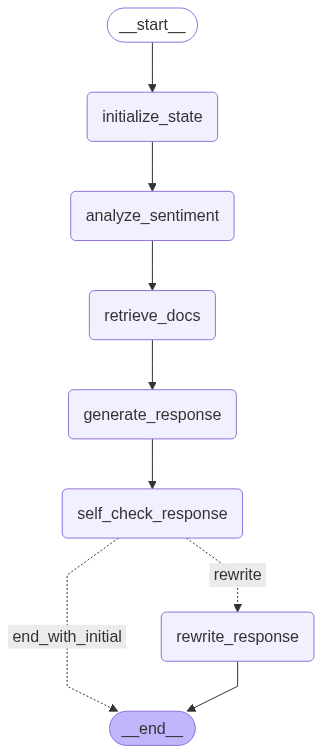

In [209]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [210]:
question = "What are the company's core values?"
inputs = {"question": question, "messages": [HumanMessage(content=question)]}

In [211]:
# This will run the full graph, including the self-correction loop if needed
for s in app.stream(inputs):
    print(s)

---INITIALIZING STATE---
{'initialize_state': {'messages': [HumanMessage(content="What are the company's core values?", additional_kwargs={}, response_metadata={})]}}
{'analyze_sentiment': {'sentiment': '**neutral**'}}
---RETRIEVING DOCUMENTS---
{'retrieve_docs': {'retrievedDocs': [Document(metadata={'language': 'en-US', 'source': 'https://www.econet.co.zw/usd-data-bundles', 'description': ' ', 'title': 'USD Data Bundles - Econet Wireless Zimbabwe'}, page_content='Personal – Internally, we will always remember that we are a company made up of individuals. These people are the company. Each one is an intrinsically valuable member of the organisation, irrespective of their gender, race or position. We will always show concern for each other in an atmosphere that is open and stimulates personal development and job satisfaction and a sense of responsibility. We believe in working in teams, in effective and confident co-operation, in environments where honest praise, constructive criticisms

In [212]:
# Get the final state to see the result
final_state = app.invoke(inputs)

---INITIALIZING STATE---
---RETRIEVING DOCUMENTS---
---ROUTING BASED ON CHECK RESULT: Correct---


In [213]:
# The final response is either the initial or the rewritten one
# based on the conditional logic
final_response = final_state.get("initial_response")
if final_state.get("self_check_result") == "Incorrect":
    final_response = final_state.get("final_response")


In [215]:
    
print("\n---FINAL RESPONSE SENT TO USER---")
print(f"Sentiment: {final_state['sentiment']}")
print(f"Self-Check Result: {final_state['selfCheckResult']}")
print(f"Response: {final_response}")


---FINAL RESPONSE SENT TO USER---
Sentiment: **neutral**
Self-Check Result: Correct
Response: None
